In [6]:
import ROOT, os, sys, glob
from math import *
ROOT.EnableImplicitMT(4); 

In [7]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [8]:
rdf = ROOT.RDataFrame("Events","/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root")

In [4]:
rdf.Describe()

Dataframe from TChain Events in file /eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root

Property                Value
--------                -----
Columns in total           34
Columns from defines        0
Event loops run             0
Processing slots            4

Column          Type                            Origin
------          ----                            ------
GenMu_charge    ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_d0        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_eta       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_isFromTau ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_isPrompt  ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_mass      ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_phi       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_pt        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_vz        ROOT::VecOps::RVec<Float_t>     Dataset
TkMu_GenMuFlav  ROOT::VecOps::RVec<UChar_t>     Dataset
TkMu_GenMuIdx

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


Processed 400000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


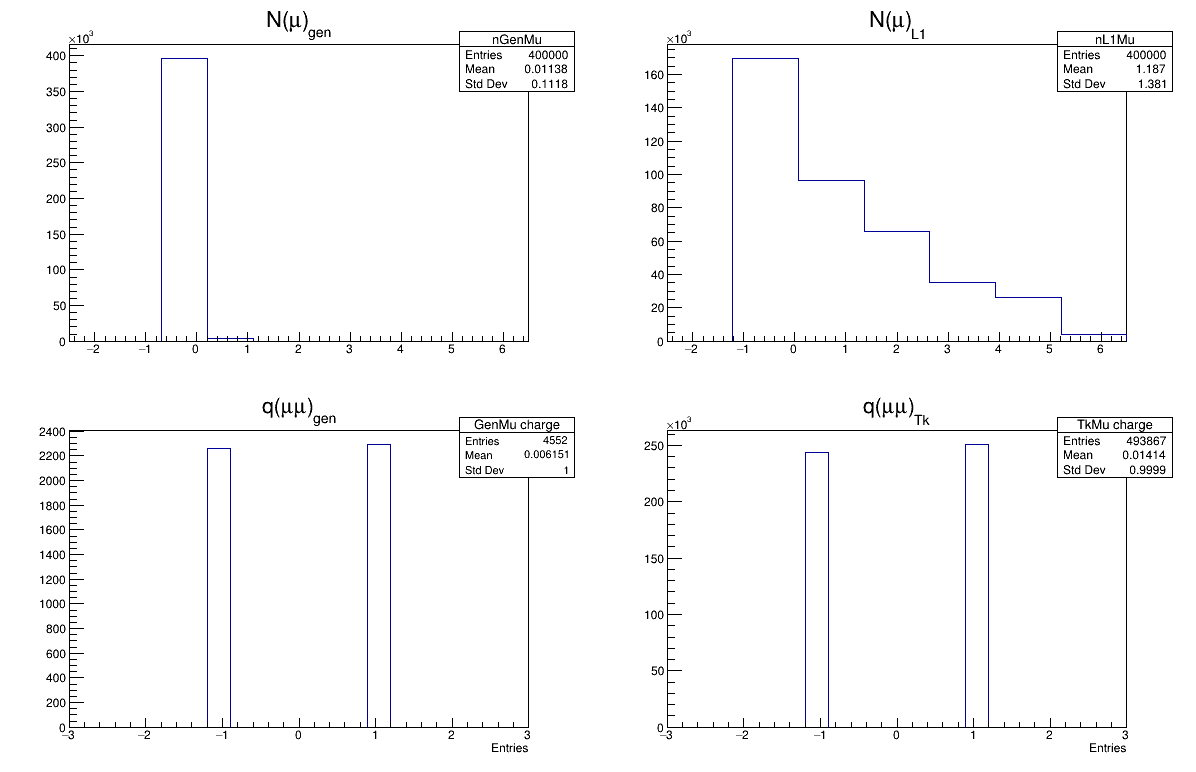

In [10]:
hNGen = rdf.Histo1D(("nGenMu","N(#mu)_{gen}",10,-2.5,6.5), "nGenMu")
# rdf.Histo1D(("<for the std>","<title of the graph>",10,-0.5,6.5), "<dataset which is plotted, this is a column  in the rdf>")

hNL1 = rdf.Histo1D(("nL1Mu","N(#mu)_{L1}",7,-2.5,6.5), "nTkMu")
hGen_charge = rdf.Histo1D(("GenMu charge","q(#mu#mu)_{gen};Entries",20,-3,3),"GenMu_charge")
hL1_charge = rdf.Histo1D(("TkMu charge","q(#mu#mu)_{Tk};Entries",20,-3,3),"TkMu_charge")
entries = rdf.Count().GetValue()
print(f"Processed {entries} entries.")

##what us nGenmu and nTkmu

## And plot it
c1 = ROOT.TCanvas("c1","c1", 1200, 800)
c1.Divide(2,2) #divides the page into two columns for diplay
for i, h in enumerate([hNGen, hNL1, hGen_charge, hL1_charge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 400000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


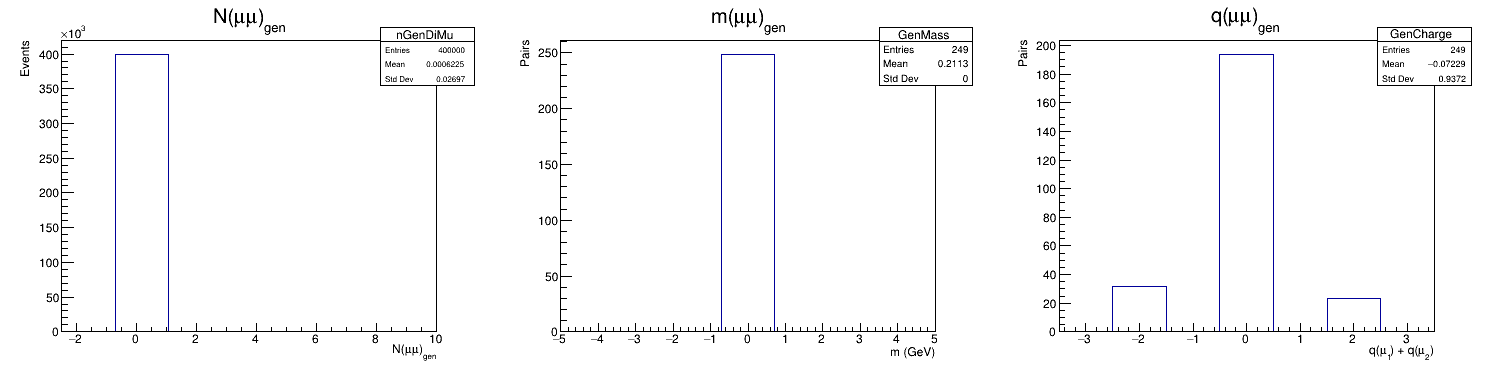

In [11]:
## Now we make pairs of muons
## This needs a bit of inlined C++ code
def makeDimuonPairs(name, rdf):
    ## define 4-vectors in cartesian coordinates, for easier 
    #rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
    ## make indices of all the pairs
    rdf = rdf.Define(f"{name}DiMu_indices", f"""
        std::vector<std::pair<int,int>> ret; 
        for (int i = 0, n = n{name}Mu; i < n; ++i) 
            for (int i2 = i+1; i2 < n; ++i2) 
                ret.emplace_back(i,i2);
        return ret;""")
    ## Make the number of dimuons, for convenience later
    rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_mass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(({name}Mu_mass[pair.first]+{name}Mu_mass[pair.second]));
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_charge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    return rdf;


rdf_gendimu = makeDimuonPairs("Gen", rdf)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNGenPairs = rdf_gendimu.Histo1D(("nGenDiMu","N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",7,-2.5,10), "nGenDiMu")
hGenPairMass = rdf_gendimu.Histo1D(("GenMass","m(#mu#mu)_{gen};m (GeV);Pairs",7,-5,5), "GenDiMu_mass")
hGenPairCharge = rdf_gendimu.Histo1D(("GenCharge","q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",7,-3.5,3.5), "GenDiMu_charge")
entries = rdf_gendimu.Count().GetValue()
print(f"Processed {entries} entries.")
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGenPairs,hGenPairMass,hGenPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [ ]:
rdf_tkdimu = makeDimuonPairs("Tk", rdf_gendimu)

hNTkPairs = rdf_tkdimu.Histo1D(("NTKDiMu","N(#mu#mu)_{Tk};;Events",25,-4,70),"nTkDiMu")
hTkPairMass = rdf_tkdimu.Histo1D(("TKDiMu mass","m(#mu#mu)_{Tk};m(GeV)",7,0,6),"TkDiMu_mass")
hTkPairCharge = rdf_tkdimu.Histo1D(("TKDiMu Charge","q(#mu#mu)_{Tk};q",7,-3.5,3.5),"TkDiMu_charge")
entries = rdf_tkdimu.Count().GetValue()
print(f"Processed {entries} entries.")
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNTkPairs,hTkPairMass,hTkPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [ ]:
def makemorevariables(name,rdf):
    #beam separation
    rdf = rdf.Define(f"{name}DiMu_dz",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]);
    return ret;""")
    
    #min pT
    rdf = rdf.Define(f"{name}DiMu_minPt", f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
    return ret;""")
    
    return rdf;

rdf_dimorevar = makemorevariables("Tk",makemorevariables("Gen",rdf_tkdimu))
hgenDiMu_sep = rdf_dimorevar.Histo1D(("genDiMu sep","dz(#mu#mu)_{gen}Events",100,-0.5,0.5), "GenDiMu_dz")
hgenDiMu_minPt = rdf_dimorevar.Histo1D(("genDiMu minPt","min p_{T}(#mu#mu)_{gen};Events",100,-0.5,20), "GenDiMu_minPt")
htkDiMu_sep = rdf_dimorevar.Histo1D(("TkDiMu sep","dz(#mu#mu)_{Tk}Events",100,-25,25), "TkDiMu_dz")
htkDiMu_minPt = rdf_dimorevar.Histo1D(("TkDiMu minPt","min p_{T}(#mu#mu)_{Tk};Events",100,1,20), "TkDiMu_minPt")
entries = rdf_gendimu.Count().GetValue()
print(f"Processed {entries} entries.")
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(2,2)
for i, h in enumerate([hgenDiMu_sep, hgenDiMu_minPt, htkDiMu_sep, htkDiMu_minPt]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()